<a href="https://colab.research.google.com/github/AbdellatifMamoun/Projet-Long/blob/main/ResNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intoduction (Dataset, pre-trained model ResNet50, Rescaling)

In [ ]:
# import "colorectal_histology" Dataset :
import tensorflow_datasets as tfds
ds, info = tfds.load('colorectal_histology', data_dir = '/Users/abdel/input', split='train', shuffle_files=True, with_info=True)

Shuffling and writing examples to /Users/abdel/input/colorectal_histology/2.0.0.incompleteWWPMSF/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /Users/abdel/input/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Get dataset informations :
print(info)

tfds.core.DatasetInfo(
    name='colorectal_histology',
    version=2.0.0,
    description='Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.',
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    total_num_examples=5000,
    splits={
        'train': 5000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susanne M and Schad, Lothar R and Gaiser, Timo and Marx, Alexander and Z{"o}llner, Frank Gerrit},
      journal={Scientific reports},
      volume={6},
      pages={27988},
      y

In [ ]:
# Import necessary modules :
## import Architecture "ResNet-50"
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
##
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
##
import keras
from keras.models import Model
##
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import optimizers
#
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

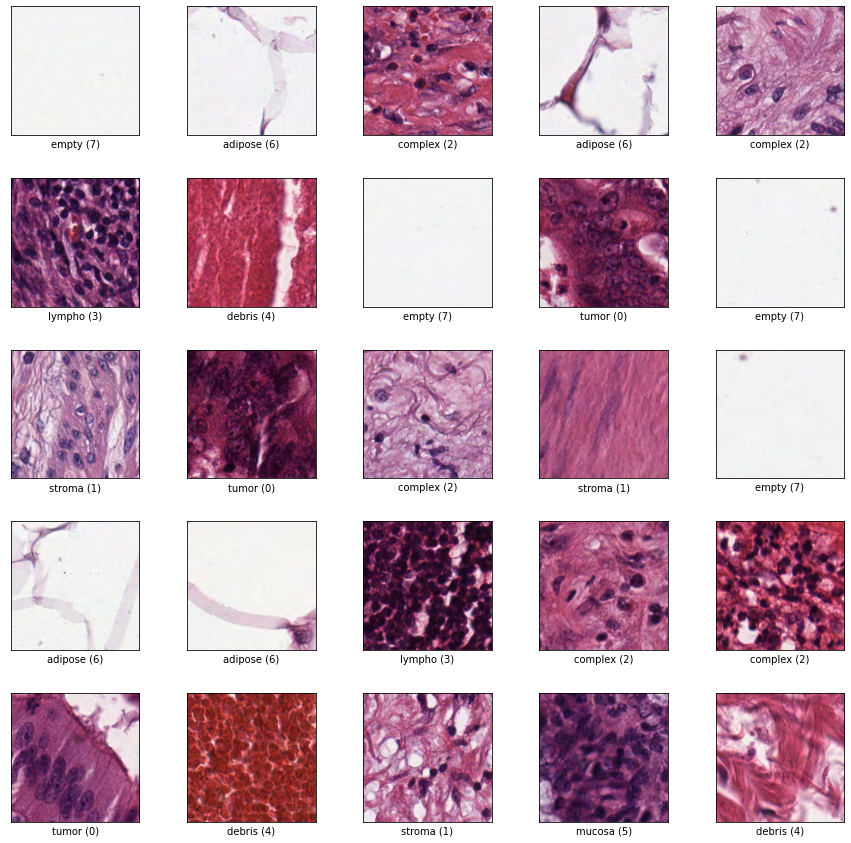

In [ ]:
# Show examples of dataset
examples = tfds.show_examples(ds, info, rows=5, cols=5)


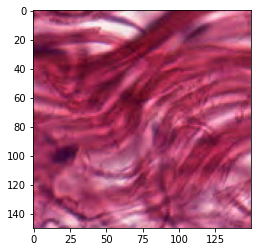

In [ ]:
# try to get images (by indexing ?) without labels
imgList = list(ds)
img0 = imgList[0]
pil_img = image.array_to_img(img0.get('image')) 
imgplot = plt.imshow(pil_img)
plt.show()


In [ ]:
# absolute path for our dataset : 
data_path = '/Users/abdel/input/downloads/extracted/ZIP.zeno.org_reco_5316_file_Kath_text_2016_imaqL7TPMR0wf27knUqk31h7Z3Aye3ukvUAeDFu7zhZbcQ.zip/Kather_texture_2016_image_tiles_5000'

# Rescaling -- Data augmentation :
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=(150, 150),
        batch_size= 20,
        class_mode= 'categorical')

Found 5000 images belonging to 8 classes.


In [ ]:
# pre trained model "ResNet-50"
resnet = ResNet50(include_top=False, input_shape=(150,150,3), weights='imagenet')
resnet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
__________________________

# Deep Clustering

In [ ]:
# Extracting features with RESNET-50  pre-trained model :

sample_count = 5000
batch_size = 20
features = np.zeros(shape=(sample_count, 5, 5, 2048))
images = np.zeros(shape=(sample_count, 150, 150, 3))
labels = np.zeros(shape=(sample_count, 8))
i=0
for inputs, lab in train_generator:
    images[i*batch_size:(i+1)*batch_size] = inputs
    labels[i*batch_size:(i+1)*batch_size] = lab
    features[i*batch_size:(i+1)*batch_size]= resnet.predict(inputs)
    i+=1

#### These two following cellules consume terribly the ammount storage while other architectures does not !!

ValueError: ignored

In [ ]:
# Discovering some features :
features.shape[1]

In [ ]:
## Vectorizing features data: 
vect_feats = features.reshape(-1, features.shape[1]*features.shape[2]*features.shape[3])
print('shape of vectorized data :', vect_feats.shape) 


In [ ]:
# Clustering algorithms : k-means

## PCA algorithms : Reducing principal components
cl = StandardScaler().fit_transform(vect_feats)
variance = 0.98
pca = PCA(variance)
pca.fit(cl)  #fit the data according to our PCA instance
cl = pca.transform(cl)

## Advantages : Reduced dimenssion + reducing principal components 
print("Number of components before PCA  = " + str(vect_feats.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_)) #dimension reduced 
print("Dimension of our data after PCA  = " + str(cl.shape))

##
kmeans = KMeans(init = "k-means++", n_clusters = 8, n_init =20 )
kmeans.fit(cl)
klabels = kmeans.labels_ 

In [ ]:
## Visualize the clusters using scatter plot
clus = StandardScaler().fit_transform(vect_feats)
tsne = TSNE(n_components=2, random_state=0)
y_feat = tsne.fit_transform(clus)
tsne_data = np.vstack((tsne_data.T,labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", size = 6).map(plt.scatter,'Dim_1', 'Dim_2' ).add_legend()
plt.show()

In [ ]:
id_cluster = 1 
samples = 100
cluster_members = (klabels == id_cluster)
fig = plt.figure(figsize=(8,8))
m=0
p=1
for ex in ds:
  if cluster_members[m]:
      img= ex['image']
      label = ex['label']
      fig.add_subplot(5,5,p)
      plt.imshow(image.array_to_img(img))
      plt.title(str(label.numpy()))
      p+=1
  m+=1
  if p > 25:
      break
    
## Comment : The result are arbitary a bit as excepted, we need fine tuning !!

In [ ]:
fig = plt.figure(figsize=(10,10))
m=0
p=1
while True : 
  if my_members[m]:
      img= images[m] 
      label = list(labels[m]).index(1)
      fig1.add_subplot(5,5,p) 
      plt.imshow(img)
      plt.title(str(label))
      p+=1
  m+=1
  if p > 25:
      break
plt.show()

# Nouvelle section

In [ ]:
# learning
START = 1
END = 25
LAMBDA = 0.85
NUM_EPOCH = 20
sample_count = 5000
batch_size = 20
NUM_CLUSTER = 8
# iterate
for ckpt in range(START, END+1):
  previous_model = load_model('checkpoint/%d.ckpt'%(ckpt-1))
  net = Model(input=previous_model.input, output=previous_model.get_layer('avg_pool').output)
  
  # extract features
  
  features = np.zeros(shape=(sample_count, 5, 5, 2048))
  i=0
  for inputs, lab in train_generator:
    features[i*batch_size:(i+1)*batch_size]= resnet.predict(inputs)
    i+=1
    if i*batch_size >= sample_count:
        break
  
  # clustering
  features = PCA(features.reshape(-1, features.shape[1]*features.shape[2]*features.shape[3]))
  kmeans = KMeans(init = "k-means++", n_clusters = NUM_CLUSTER, n_init =20)
  kmeans.fit(features)
  
  # select centers
  labells = kmeans.labels_
  centers = kmeans.cluster_centers_

  # retrain: fine tune
  init_model = load_model('checkpoint/0.ckpt')
  x = init_model.get_layer('avg_pool').output
  x = Flatten(name='flatten')(x)
  x = Dropout(0.5)(x)
  x = Dense(NUM_CLUSTER, activation='softmax', name='fc8', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(x)
  net = Model(input=init_model.input, output=x)
  for layer in net.layers:
    layer.trainable = True
  net.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy')
  net.fit_generator(datagen.flow(images, labels, batch_size=BATCH_SIZE), steps_per_epoch=len(images)/BATCH_SIZE+1, epochs=NUM_EPOCH)
  net.save('checkpoint/%d.ckpt'%ckpt)